In [32]:
# import the necessary packages
import opensmile
import sys
import os
from os import path
from tqdm import tqdm
import glob
import numpy as np
import matplotlib
import pandas as pd
import audiofile
from rasta import *
from sklearn.preprocessing import normalize
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams["figure.figsize"] = (10, 10)

In [33]:
# Read the spoken document for the STD task
f1 = "d_i"
f2 = "d_j"
d1 = "{}.wav".format(f1)
d2 = "{}.wav".format(f2)
y1, sr = audiofile.read(d1)
y2, sr = audiofile.read(d2)
print("Sampling rate :", sr)

Sampling rate : 16000


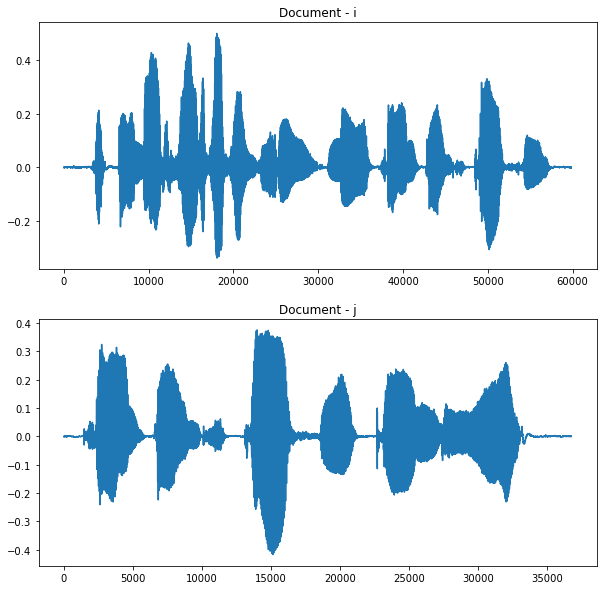

In [34]:
#plot the wave file 
fig, axs = plt.subplots(2,1)
axs[0].plot(y1)
axs[0].set_title("Document - i")
axs[1].plot(y2)
axs[1].set_title("Document - j")
plt.show()

In [35]:
# compute the RASTA-PLP spectrogram 
w_time = 0.02 # seconds 
h_time = 0.02 # seconds 
mel = 9 
cepstra1, spectra1 = rastaplp(y1, sr, win_time=w_time,hop_time=h_time, modelorder=mel)
cepstra2, spectra2 = rastaplp(y2, sr, win_time=w_time,hop_time=h_time, modelorder=mel)

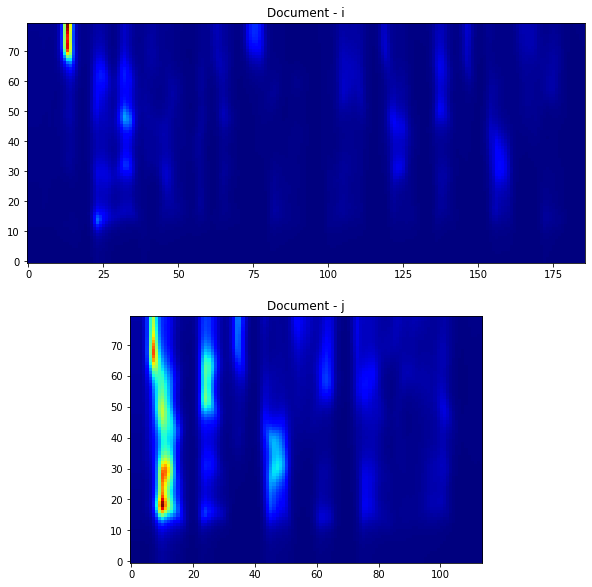

In [37]:
# plot the feature vector 
fig, axs = plt.subplots(2,1)
c_map='jet'
im1 = axs[0].imshow(spectra1,cmap=c_map, origin='lower')
axs[0].set_title("Document - i")
im2 = axs[1]. imshow(spectra2,cmap=c_map, origin='lower')
axs[1].set_title("Document - j")
plt.show()

In [38]:
def cosine_sim(a,b): 
	dist = distance.cosine(a,b)
	return 1-dist

In [39]:
# compute the similarity matrix 
feats_spkr1 = spectra1
feats_spkr2 = spectra2
c, r1 = feats_spkr1.shape # di
c, r2 = feats_spkr2.shape # dj
sim_mat = np.zeros((r1, r2))
norm_feats1 = normalize(feats_spkr1, axis=0)
norm_feats2 = normalize(feats_spkr2, axis=0)
for i in range(r1): 
    for j in range(r2): 
        x = norm_feats1[:,i]
        y = norm_feats2[:,j]
        sim_mat[i,j] = cosine_sim(x,y) # cosine similarity
r, c = sim_mat.shape

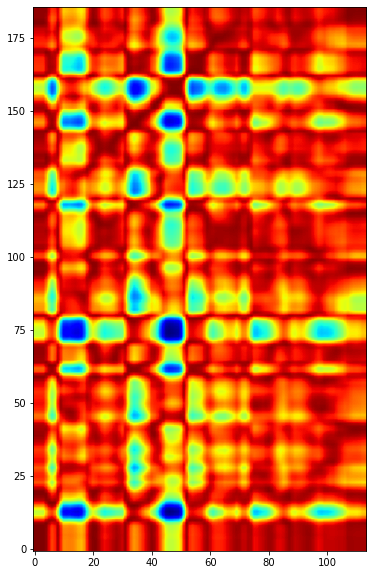

In [40]:
# plot the similarity matrix 
fig, axs = plt.subplots(1,1)
c_map='jet'
img_sim = axs.imshow(sim_mat,cmap=c_map, origin='lower')
plt.show()

In [41]:
# binarise the similarity matrix 
eta = 0.97 # obtained based on the experiment
sim_out = np.where(sim_mat>eta,1,0) # for correlation

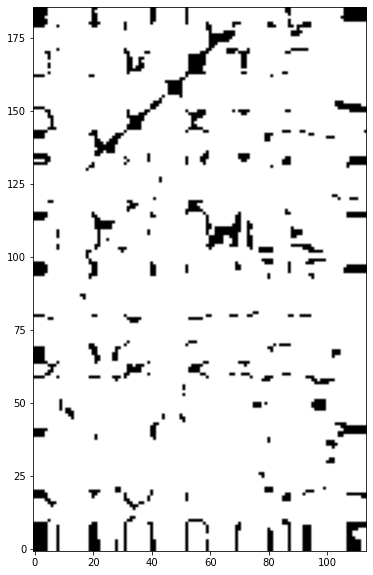

In [42]:
# plot the binarised similarity matrix 
fig, axs = plt.subplots(1,1)
c_map='binary'
img_sim = axs.imshow(sim_out,cmap=c_map, origin='lower')
plt.show()

In [43]:
def diag_sim(mat): 
    '''
        captures the potential diagonals to detect the similarity pattern between spoken terms
    '''
    C = np.zeros((mat.shape[0],  mat.shape[1]), int)
    match_score=1
    for i in range(0, mat.shape[0]): 
        for j in range(0, mat.shape[1]):
            if(mat[i,j]==1):
                if(i>0 and j>0):
                    match =  match_score+C[i - 1, j - 1]
                    C[i, j] = match
                elif(i==0 or j==0):
                    C[i,j] = match_score


    row = mat.shape[0]
    clm = mat.shape[1]
    r_index = (row-1)*-1
    c_index = clm-1
    diags = (r_index*-1)+1+(c_index)
    h_cost = np.zeros((diags))
    h_cost_l =[]
    for i in range(r_index,0,1): 
        diags = C.diagonal(i)
        grad = np.array(diags)
        seq_count = np.sum(grad)
        h_cost_l.append((i,seq_count)) # add the diagonal and cost

    h_cost_r=[]
    for i in range(0,c_index,1): 
        diags = C.diagonal(i)
        grad = np.array(diags)
        seq_count = np.sum(grad)
        h_cost_r.append((i, seq_count))

    return h_cost_l, h_cost_r, C

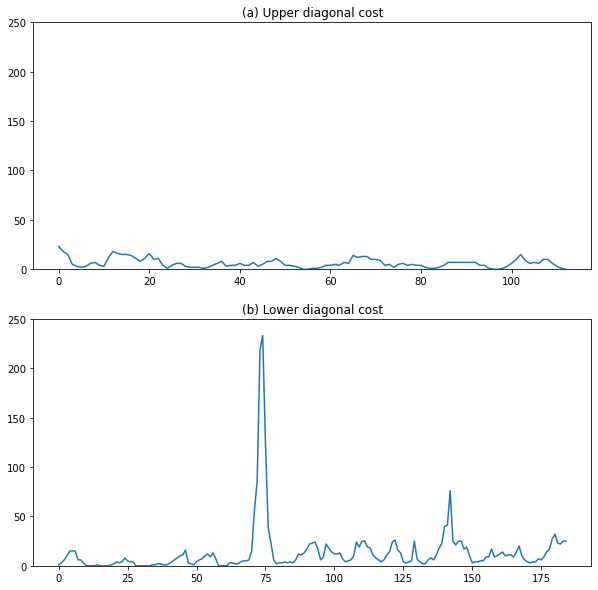

In [56]:
# Apply the DF search method and capture the diagonal cost of the similarity region
h_cost_l, h_cost_r, C = diag_sim(sim_out)
up_dia_cost = [b for a, b in h_cost_r]
low_dia_cost = [b for a, b in h_cost_l]
fig, axs = plt.subplots(2,1)
c_map='binary'
axs[0].plot(up_dia_cost)
axs[1].plot(low_dia_cost)
axs[0].set_ylim(0,250)
axs[1].set_ylim(0,250)
axs[0].set_title("(a) Upper diagonal cost")
axs[1].set_title("(b) Lower diagonal cost")
plt.show()

The peak in the lower diagonal cost in (b) indicates the significant similarity region captured by the proposed DF search

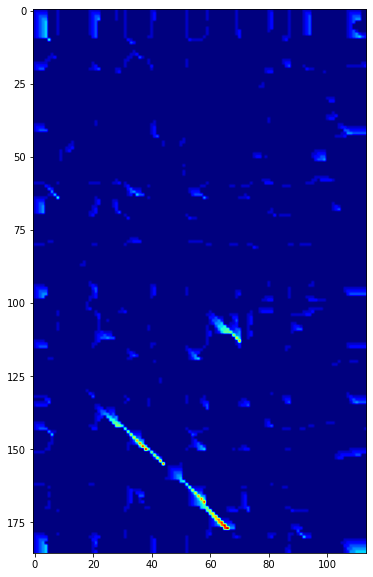

In [58]:
fig, axs = plt.subplots()
c_map='jet'
img1 = axs.imshow(C,cmap=c_map, origin='upper')
plt.show()